In [336]:
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import pickle
import warnings
from keras.datasets import mnist

In [337]:
# Machine Epsilon (needed to calculate logarithms)
eps = np.finfo(np.float64).eps

In [338]:
# Loading MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# x contains the images (features to our model)
# y contains the labels 0 to 9
# print test data
print(x_test.shape)
print(y_test.shape)

(10000, 28, 28)
(10000,)


In [339]:
# Normalizing the inputs between 0 and 1
x_train = x_train / 255
x_test = x_test / 255

In [340]:
# Flattening the image as we are using
# dense neural networks
x_train = x_train.reshape(-1, x_train.shape[1] * x_train.shape[2])
x_test = x_test.reshape(-1, x_test.shape[1] * x_test.shape[2])
# print data shape after reshaping
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


In [341]:
# Converting to one-hot representation
identity_matrix = np.eye(10)
y_train = identity_matrix[y_train]
y_test = identity_matrix[y_test]

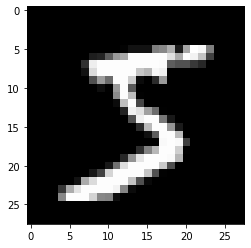

In [342]:
# Plotting sample image
plt.imshow(x_train[0].reshape(28, 28), cmap="gray")
plt.show()

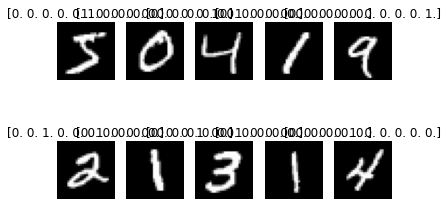

In [343]:
# Plotting the images
fig, ax = plt.subplots(2, 5)
for i in range(10):
    ax[i // 5, i % 5].imshow(x_train[i].reshape(28, 28), cmap="gray")
    ax[i // 5, i % 5].set_title(str(y_train[i]))
    ax[i // 5, i % 5].axis("off")
plt.show()

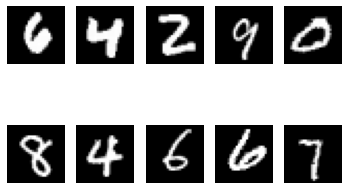

In [344]:
# Plotting the images
fig, ax = plt.subplots(2, 5)
for i, ax in enumerate(ax.flatten()):
    # im_idx = np.argwhere(y_train == i)[0]
    im_idx = np.random.randint(0, x_train.shape[0])
    # plottable_image = np.reshape(x_train[im_idx], (28, 28))
    plottable_image = x_train[im_idx].reshape(28, 28)
    ax.set_axis_off()
    ax.imshow(plottable_image, cmap="gray")

### single layer neural network with only forward pass

In [346]:
def soft_max(x):
    """
    Arguments: numpy array

    Returns: numpy array after applying
    softmax function to each
    element
    """

    # Subtracting max of x from each element of x for numerical
    # stability as this results in the largest argument to
    # exp being 0, ruling out the possibility of overﬂow
    # Read more about it at :
    # https://www.deeplearningbook.org/contents/numerical.html

    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

In [348]:
class Model:
    """
    Single layer Neural Network
    """

    def __init__(self, input_shape, n_classes):
        # Number of output classes
        self.n_classes = n_classes
        # Parameters/Weights of our network which we will be updating
        self.weights = np.random.randn(input_shape, n_classes)

    def forward(self, x):
        """
        Arguments: numpy array containing the features,
        expected shape of input array is
        (batch size, number of features)

        Returns: numpy array containing the probability,
        expected shape of output array is
        (batch size, number of classes)

        """
        # Multiplying weights with inputs
        x = np.dot(x, self.weights)
        # Applying softmax function on each row
        x = np.apply_along_axis(soft_max, 1, x)
        return x

    def __call__(self, x):
        """
        This dunder function
        enables your model to be callable

        When the model is called using model(x),
        forward method of the model is called internally
        """
        return self.forward(x)

    def evaluate(self, x, y, weights=None):
        """
        Arguments : x — numpy array of shape (batch size,number of features),
        y — numpy array of shape (batch size,number of classes),
        weights — numpy array containing the parameters of the model

        Returns : Scalar containing the mean of the categorical cross-entropy loss
        of the batch
        """

        if weights is not None:
            self.weights = weights

        # Calculating the negative of cross-entropy loss (since
        # we are maximizing this score)
        # Adding a small value called epsilon
        # to prevent -inf in the output

        log_predicted_y = np.log(self.forward(x) + eps)
        return (log_predicted_y * y).mean()

In [350]:
def optimize(
    model,
    x,
    y,
    top_n=5,
    n_pop=20,
    n_iter=10,
    sigma_error=1,
    error_weight=1,
    decay_rate=0.95,
    min_error_weight=0.01,
):

    """
    Arguments : model — Model object(single layer neural network here),
    x — numpy array of shape (batch size, number of features),
    y — numpy array of shape (batch size, number of classes),
    top_n — Number of elite parameters to consider for calculating the
    best parameter by taking mean
    n_pop — Population size of the parameters
    n_iter — Number of iteration
    sigma_error — The standard deviation of errors while creating
    population from best parameter
    error_weight — Contribution of error for considering new population
    decay_rate — Rate at which the weight of the error will reduce after
    each iteration, so that we don’t deviate away at the
    point of convergence. It controls the balance between
    exploration and exploitation


    Returns : Model object with updated parameters/weights
    """

    # Model weights have been randomly initialized at first
    best_weights = model.weights

    for i in range(n_iter):
        # Generating the population of parameters
        pop_weights = [
            best_weights
            + error_weight * sigma_error * np.random.randn(*model.weights.shape)
            for i in range(n_pop)
        ]

    # Evaluating the population of parameters
    evaluation_values = [model.evaluate(x, y, weight) for weight in pop_weights]

    # Sorting based on evaluation score
    weight_eval_list = zip(evaluation_values, pop_weights)

    weight_eval_list = sorted(weight_eval_list, key=lambda x: x[0], reverse=True)

    evaluation_values, pop_weights = zip(*weight_eval_list)

    # Taking the mean of the elite parameters
    best_weights = np.stack(pop_weights[:top_n], axis=0).mean(axis=0)

    # Decaying the weight
    error_weight = max(error_weight * decay_rate, min_error_weight)

    model.weights = best_weights

    return model

In [351]:
# Instantiating our model object
model = Model(input_shape=x_train.shape[1], n_classes=10)
# evaluating the model
print("Evaluation score of the model is : ", model.evaluate(x_train, y_train))
# Running it for 200 steps
for i in tqdm.tqdm(range(10)):
    model = optimize(model, x_train, y_train, top_n=10, n_pop=100, n_iter=1)

    # Test data cross-entropy loss
    print(
        "Test Cross-Entropy Loss of the model is : ",
        -1 * model.evaluate(x_test, y_test),
    )
    # Test Accuracy
    print(
        "Test Accuracy of the model is : ",
        model.evaluate(x_test, y_test, model.weights),
    )

Evaluation score of the model is :  -1.5383347300965424


 10%|█         | 1/10 [01:07<10:05, 67.26s/it]

Test Cross-Entropy Loss of the model is :  1.2010583249678053
Test Accuracy of the model is :  -1.2010583249678053


 20%|██        | 2/10 [02:15<09:00, 67.61s/it]

Test Cross-Entropy Loss of the model is :  1.0038517683000345
Test Accuracy of the model is :  -1.0038517683000345


 30%|███       | 3/10 [03:22<07:53, 67.66s/it]

Test Cross-Entropy Loss of the model is :  0.8920896882042317
Test Accuracy of the model is :  -0.8920896882042317


 40%|████      | 4/10 [04:29<06:44, 67.43s/it]

Test Cross-Entropy Loss of the model is :  0.8083448448121475
Test Accuracy of the model is :  -0.8083448448121475


 50%|█████     | 5/10 [05:37<05:36, 67.35s/it]

Test Cross-Entropy Loss of the model is :  0.7197115350984574
Test Accuracy of the model is :  -0.7197115350984574


 60%|██████    | 6/10 [06:45<04:31, 67.86s/it]

Test Cross-Entropy Loss of the model is :  0.6828093640807544
Test Accuracy of the model is :  -0.6828093640807544


 70%|███████   | 7/10 [07:53<03:23, 67.67s/it]

Test Cross-Entropy Loss of the model is :  0.6613671523369558
Test Accuracy of the model is :  -0.6613671523369558


 80%|████████  | 8/10 [08:59<02:14, 67.31s/it]

Test Cross-Entropy Loss of the model is :  0.6198570654838259
Test Accuracy of the model is :  -0.6198570654838259


 90%|█████████ | 9/10 [10:06<01:07, 67.09s/it]

Test Cross-Entropy Loss of the model is :  0.5852355735668846
Test Accuracy of the model is :  -0.5852355735668846


100%|██████████| 10/10 [11:12<00:00, 67.25s/it]

Test Cross-Entropy Loss of the model is :  0.5492417123432419
Test Accuracy of the model is :  -0.5492417123432419


Results: After training for 200 iterations the test accuracy was ~ 85% and cross-entropy loss was ~ 0.28. This is comparable to a single layer neural network trained with back propagation. Note that we haven’t even used decay here as n_iter was set to 1.

In [352]:
# Saving the model for later use
pickle.dump(model, open("model.pkl", "wb"))